# Apply a trained SRFlow model

## Reproduce using our Setup

- Use the ./setup.sh
- It install the all packages from the requirements.txt
- If this notebook does not work, copy the code to start it from setup.py
- The python interpreter should be '../myenv/bin/python3'

In [2]:
import sys
print(sys.executable)

/sep/minjun/anaconda3/envs/srflow/bin/python


# Initialize

In [3]:
import natsort, glob, pickle, torch

torch.cuda.is_available = lambda : False

from collections import OrderedDict
import numpy as np
import os
import matplotlib.pyplot as plt

import options.options as option
from models import create_model
from imresize import imresize

import Measure

def find_files(wildcard): return natsort.natsorted(glob.glob(wildcard, recursive=True))

from PIL import Image
def imshow(array):
    display(Image.fromarray(array))

from test import load_model, fiFindByWildcard, imread

def pickleRead(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [4]:
# Convert to tensor
def t(array): return torch.Tensor(np.expand_dims(array.transpose([2, 0, 1]), axis=0).astype(np.float32)) 

# convert to image
def rgb(t): return (t[0] if len(t.shape) == 4 else t).detach().cpu().numpy().transpose([1, 2, 0]).astype(np.uint8)

# List model files

If you do not see models here, download them as in `setup.sh`.

In [5]:
find_files("/sep/minjun/srflow/pretrained_models/*.pth")

['/sep/minjun/srflow/pretrained_models/RRDB_CelebA_8X.pth',
 '/sep/minjun/srflow/pretrained_models/RRDB_CelebA_8X_2.pth',
 '/sep/minjun/srflow/pretrained_models/RRDB_DF2K_4X.pth',
 '/sep/minjun/srflow/pretrained_models/RRDB_DF2K_8X.pth',
 '/sep/minjun/srflow/pretrained_models/SRFlow_CelebA_8X.pth',
 '/sep/minjun/srflow/pretrained_models/SRFlow_CelebA_8X_2.pth',
 '/sep/minjun/srflow/pretrained_models/SRFlow_DF2K_4X.pth',
 '/sep/minjun/srflow/pretrained_models/SRFlow_DF2K_8X.pth']

# Configuration files


In [6]:
find_files("confs/*.yml")

['confs/RRDB_CelebA_8X.yml',
 'confs/RRDB_DF2K_4X.yml',
 'confs/RRDB_DF2K_8X.yml',
 'confs/SRFlow_CelebA_8X.yml',
 'confs/SRFlow_DF2K_4X.yml',
 'confs/SRFlow_DF2K_8X.yml',
 'confs/SRFlow_seismic.yml']

# List dataset directories


In [7]:
find_files("/sep/minjun/srflow//datasets/**/")

['/sep/minjun/srflow//datasets/',
 '/sep/minjun/srflow//datasets/celebA-validation-gt/',
 '/sep/minjun/srflow//datasets/celebA-validation-x8/',
 '/sep/minjun/srflow//datasets/data_MNIST/',
 '/sep/minjun/srflow//datasets/data_MNIST/MNIST/',
 '/sep/minjun/srflow//datasets/data_MNIST/MNIST/processed/',
 '/sep/minjun/srflow//datasets/data_MNIST/MNIST/raw/',
 '/sep/minjun/srflow//datasets/div2k-validation-modcrop8-gt/',
 '/sep/minjun/srflow//datasets/div2k-validation-modcrop8-x4/',
 '/sep/minjun/srflow//datasets/div2k-validation-modcrop8-x8/',
 '/sep/minjun/srflow//datasets/mj_data/',
 '/sep/minjun/srflow//datasets/mj_data/hr/',
 '/sep/minjun/srflow//datasets/mj_data/hr_rc/',
 '/sep/minjun/srflow//datasets/mj_data/lr/',
 '/sep/minjun/srflow//datasets/mj_data/pkls/',
 '/sep/minjun/srflow//datasets/mj_data_test/',
 '/sep/minjun/srflow//datasets/mj_data_test/hr/',
 '/sep/minjun/srflow//datasets/mj_data_test/hr_rc/',
 '/sep/minjun/srflow//datasets/mj_data_test/lr/',
 '/sep/minjun/srflow//datase

In [8]:
conf_path = './confs/SRFlow_seismic.yml'

# conf_path = './confs/SRFlow_CelebA_8X.yml'

### Instancieate the Model

In [9]:
from utils.util import get_resume_paths, opt_get


def load_network(self, load_path, network, strict=True, submodule=None):
    if isinstance(network, nn.DataParallel) or isinstance(network, DistributedDataParallel):
        network = network.module
    if not (submodule is None or submodule.lower() == 'none'.lower()):
        network = network.__getattr__(submodule)
    load_net = torch.load(load_path)
    load_net_clean = OrderedDict()  # remove unnecessary 'module.'
    for k, v in load_net.items():
        if k.startswith('module.'):
            load_net_clean[k[7:]] = v
        else:
            load_net_clean[k] = v
    network.load_state_dict(load_net_clean, strict=strict)
    
def load_model(conf_path):
    opt = option.parse(conf_path, is_train=False)
    opt['gpu_ids'] = None
    opt = option.dict_to_nonedict(opt)
    model = create_model(opt)

    #model_path = opt_get(opt, ['model_path'], None)
    model.load_network(load_path='../experiments/train/models/10000_G.pth', network=model.netG)
    return model, opt

# '../experiments/train/models/400_G.pth'

In [10]:
model, opt = load_model('./confs/SRFlow_seismic.yml')

OrderedDict([('manual_seed', 10), ('lr_G', 0.00025), ('weight_decay_G', 0), ('beta1', 0.9), ('beta2', 0.99), ('lr_scheme', 'MultiStepLR'), ('warmup_iter', -1), ('lr_steps_rel', [0.5, 0.75, 0.9, 0.95]), ('lr_gamma', 0.5), ('niter', 20000), ('val_freq', 500), ('lr_steps', [10000, 15000, 18000, 19000])])
<class 'models.SRFlow_model.SRFlowModel'>


FileNotFoundError: [Errno 2] No such file or directory: '../experiments/train/models/10000_G.pth'

### Find the png paths

In [11]:
lq_paths = fiFindByWildcard(os.path.join(opt['dataroot_LR'], '*.npy'))
gt_paths = fiFindByWildcard(os.path.join(opt['dataroot_GT'], '*.npy'))
print(lq_paths, gt_paths) # For CelebA we have just 1

NameError: name 'opt' is not defined

In [29]:
# lqs = [imread(p) for p in lq_paths]
# gts = [imread(p) for p in gt_paths]

lq = np.load(lq_paths[1])
print(lq.shape)
lq = (lq-np.min(lq)) / np.max(lq-np.min(lq))
lq = imresize(lq, scalar_scale=0.25) 

gt = np.load(gt_paths[1])
gt /= np.max(gt)

gt = imresize(gt, scalar_scale=1) 

(320, 320, 3)


First LR image


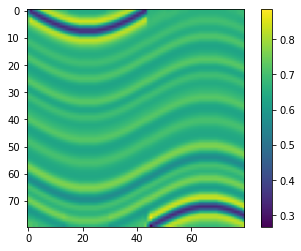

First HR image


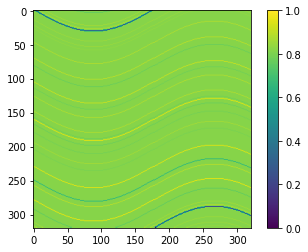

In [30]:
print("First LR image")
plt.imshow(lq[:,:,0].T)
plt.colorbar()
plt.show()
print("First HR image")
plt.imshow(gt[:,:,0].T)
plt.colorbar()
plt.show()

In [31]:
def predict(model, lr):
    model.feed_data({"LQ": t(lr)}, need_GT=False)
    model.test()
    visuals = model.get_current_visuals(need_GT=False)
    return visuals.get('rlt', visuals.get("SR"))

In [32]:
lq.shape

(80, 80, 3)

In [33]:
# # a = predict(model,lq)
# model.netG.eval()
# z = model.get_z(0.5, 10, batch_size=1, lr_shape=lq.shape) #if z is None and epses is None else z

# with torch.no_grad():
#     sr, logdet = self.netG(lr=lq, z=z, eps_std=heat, reverse=True, epses=epses)
# # self.netG.train()

# Super-Resolve using SRFlow for multiple temperatures

In [34]:
measure = Measure.Measure()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /sep/minjun/anaconda3/envs/srflow/lib/python3.7/site-packages/lpips/weights/v0.1/alex.pth


In [35]:
# z = model.get_z(0.5, 10, batch_size=1, lr_shape=t(lq).shape)

In [36]:
# with torch.no_grad():
#     sr, logdet = model.netG(lr=t(lq), z=z ,eps_std=0.5, reverse=True)

torch.Size([1, 3, 320, 320])


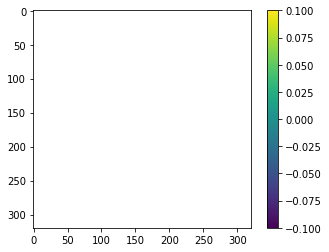

In [37]:
for temperature in np.linspace(0, 1, num=1):
    # Sample a super-resolution for a low-resolution image
    sr = (model.get_sr(lq=t(lq), heat=temperature))

    print(sr.shape)
    plt.imshow(sr[0,0,:,:].T)
    plt.colorbar()
    plt.show()
#     psnr, ssim, lpips = measure.measure(sr_np, gt.astype(np.uint8))
#     print('Temperature: {:0.2f} - PSNR: {:0.1f}, SSIM: {:0.1f}, LPIPS: {:0.2f}\n\n'.format(temperature, psnr, ssim, lpips))


In [38]:
sr

tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]]])

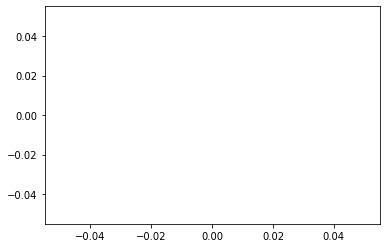

In [21]:
plt.plot(sr[0,0,0,:])

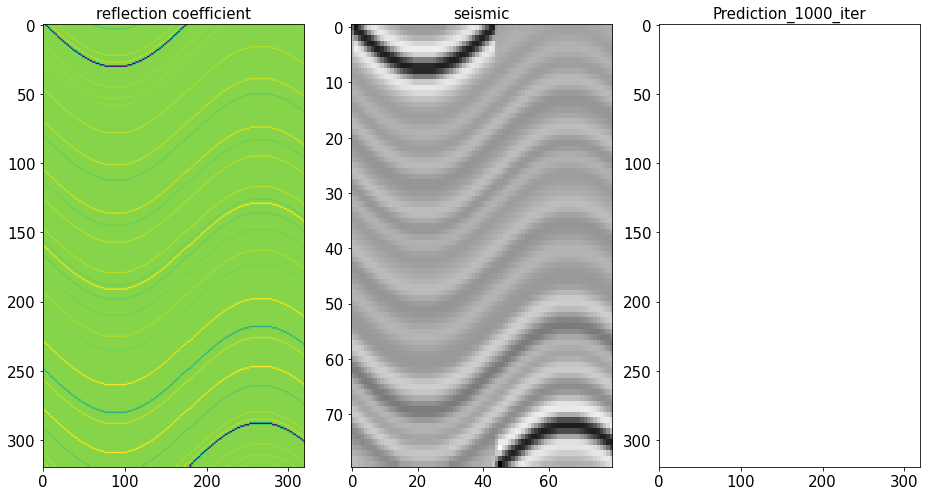

In [22]:
fig, ax = plt.subplots(1,3,figsize=(13,7))
v=0.2
ax[0].imshow(gt[:,:,0].T,aspect='auto')#,extent=[0,nx*dx/100,((nt-1)*dt*10),0.0])
ax[0].tick_params(labelsize=15)
ax[0].set_title('reflection coefficient', fontsize=15)

ax[1].imshow(lq[:,:,0].T,cmap='gray',aspect='auto')#,extent=[0,nx*dx/100,((nt-1)*dt*10),0.0])
ax[1].tick_params(labelsize=15)
ax[1].set_title('seismic',fontsize=15)

ax[2].imshow(sr[0,2,:,:].T,aspect='auto',vmin= 0.6, vmax=0.8)#,extent=[0,nx*dx/100,((nt-1)*dt*10),0.0])
ax[2].tick_params(labelsize=15)
ax[2].set_title('Prediction_1000_iter',fontsize=15)


plt.tight_layout()
plt.show()

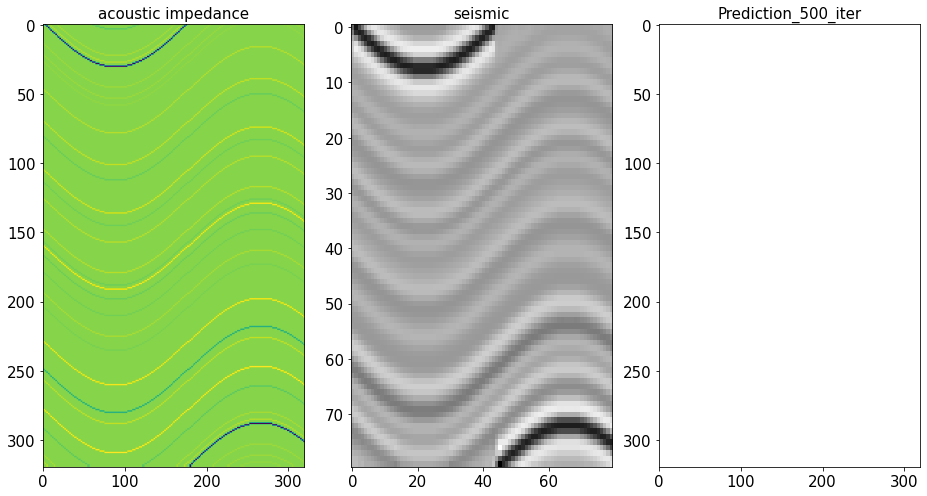

In [23]:
fig, ax = plt.subplots(1,3,figsize=(13,7))
v=0.2
ax[0].imshow(gt[:,:,0].T,aspect='auto')#,extent=[0,nx*dx/100,((nt-1)*dt*10),0.0])
ax[0].tick_params(labelsize=15)
ax[0].set_title('acoustic impedance', fontsize=15)

ax[1].imshow(lq[:,:,0].T,cmap='gray',aspect='auto')#,extent=[0,nx*dx/100,((nt-1)*dt*10),0.0])
ax[1].tick_params(labelsize=15)
ax[1].set_title('seismic',fontsize=15)

ax[2].imshow(sr[0,1,:,:].T,aspect='auto',vmin= 0.3, vmax=0.6)#,extent=[0,nx*dx/100,((nt-1)*dt*10),0.0])
ax[2].tick_params(labelsize=15)
ax[2].set_title('Prediction_500_iter',fontsize=15)


plt.tight_layout()
plt.show()

# LR Consistency

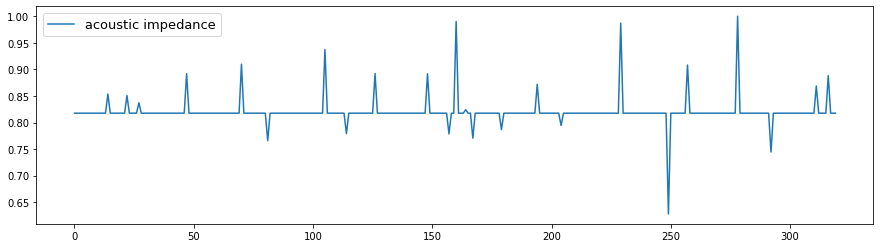

In [24]:
plt.figure(figsize=[15,4])
#plt.plot(sr[0,0,0,:],label='output')
plt.plot(gt[0,:,0],label='acoustic impedance')
plt.legend(fontsize=13)

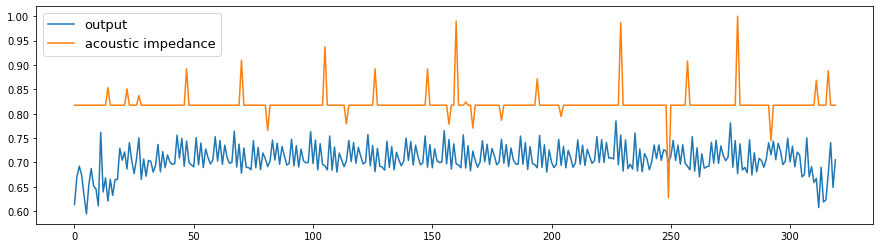

In [30]:
plt.figure(figsize=[15,4])
plt.plot(sr[0,0,0,:],label='output')
plt.plot(gt[0,:,0],label='acoustic impedance')
plt.legend(fontsize=13)

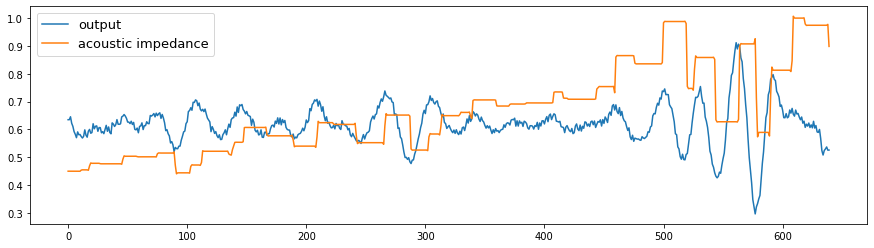

In [16]:
plt.figure(figsize=[15,4])
plt.plot(sr[0,0,0,:],label='output')
plt.plot(gt[0,:,0],label='acoustic impedance')
plt.legend(fontsize=13)

Text(0.5, 1.0, 'seismic')

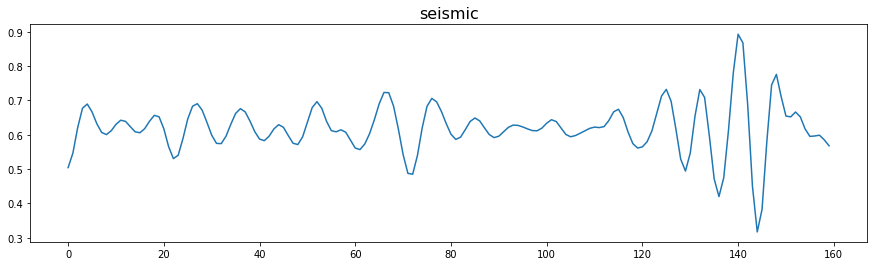

In [17]:
plt.figure(figsize=[15,4])
plt.plot(lq[0,:,0])
plt.title('seismic',fontsize=16)

In [9]:
temperature = 0.9

downsampled = lq
for idx in range(2):
    sr = rgb(model.get_sr(lq=t(downsampled), heat=temperature))
    downsampled = imresize(sr, 1/8)
    imshow(sr)


NameError: name 'lq' is not defined

In [16]:
# validation
from data import create_dataloader, create_dataset
for phase, dataset_opt in opt['datasets'].items():
        val_set = create_dataset(dataset_opt)
        val_loader = create_dataloader(val_set, dataset_opt, opt, None)

{'name': 'CelebA_160_tr', 'mode': 'LRHR_PKL', 'dataroot_GT': '/sep/minjun/srflow/datasets/mj_data/pkls/hr.pklv4', 'dataroot_LQ': '/sep/minjun/srflow/datasets/mj_data/pkls/lr_X4.pklv4', 'quant': 32, 'use_shuffle': True, 'n_workers': 4, 'batch_size': 50, 'GT_size': 160, 'use_flip': True, 'color': 'RGB', 'phase': 'train', 'scale': 4, 'data_type': 'img'}
Loaded 200 HR images with [0.35, 1.00] in 0.11s from /sep/minjun/srflow/datasets/mj_data/pkls/hr.pklv4
Loaded 200 LR images with [-0.29, 0.33] in 0.11s from /sep/minjun/srflow/datasets/mj_data/pkls/lr_X4.pklv4
{'name': 'CelebA_160_va', 'mode': 'LRHR_PKL', 'dataroot_GT': '/sep/minjun/srflow/datasets/mj_data_test/pkls/hr.pklv4', 'dataroot_LQ': '/sep/minjun/srflow/datasets/mj_data_test/pkls/lr_X4.pklv4', 'quant': 32, 'n_max': 20, 'phase': 'val', 'scale': 4, 'data_type': 'img'}
Loaded 20 HR images with [0.30, 1.00] in 0.02s from /sep/minjun/srflow/datasets/mj_data_test/pkls/hr.pklv4
Loaded 20 LR images with [-0.37, 0.41] in 0.02s from /sep/min

In [17]:
from utils import util      
avg_psnr = 0.0
idx = 0
nlls = []
for val_data in val_loader:
    idx += 1
    img_name = os.path.splitext(os.path.basename(val_data['LQ_path'][0]))[0]
    img_dir = '/sep/minjun/srflow/results/'
    util.mkdir(img_dir)

    model.feed_data(val_data)

    nll = model.test()
    if nll is None:
        nll = 0
    nlls.append(nll)

    visuals = model.get_current_visuals()
    break
    
#     sr_img = None
#     # Save SR images for reference
#     if hasattr(model, 'heats'):
#         for heat in model.heats:
#             for i in range(model.n_sample):
#                 sr_img = util.tensor2img(visuals['SR', heat, i])  # uint8
#                 save_img_path = os.path.join(img_dir,
#                                              '{:s}_{:09d}_h{:03d}_s{:d}.png'.format(img_name,
#                                                                                     current_step,
#                                                                                     int(heat * 100), i))
#                 util.save_img(sr_img, save_img_path)
#     else:
#         sr_img = util.tensor2img(visuals['SR'])  # uint8
#         save_img_path = os.path.join(img_dir,
#                                      '{:s}_{:d}.png'.format(img_name, current_step))
#         util.save_img(sr_img, save_img_path)
#     assert sr_img is not None

#     # Save LQ images for reference
#     save_img_path_lq = os.path.join(img_dir,
#                                     '{:s}_LQ.png'.format(img_name))
#     if not os.path.isfile(save_img_path_lq):
#         lq_img = util.tensor2img(visuals['LQ'])  # uint8
#         util.save_img(
#             cv2.resize(lq_img, dsize=None, fx=opt['scale'], fy=opt['scale'],
#                        interpolation=cv2.INTER_NEAREST),
#             save_img_path_lq)

#     # Save GT images for reference
#     gt_img = util.tensor2img(visuals['GT'])  # uint8
#     save_img_path_gt = os.path.join(img_dir,
#                                     '{:s}_GT.png'.format(img_name))
#     if not os.path.isfile(save_img_path_gt):
#         util.save_img(gt_img, save_img_path_gt)

#     # calculate PSNR
#     crop_size = opt['scale']
#     gt_img = gt_img / 255.
#     sr_img = sr_img / 255.
#     cropped_sr_img = sr_img[crop_size:-crop_size, crop_size:-crop_size, :]
#     cropped_gt_img = gt_img[crop_size:-crop_size, crop_size:-crop_size, :]
#     avg_psnr += util.calculate_psnr(cropped_sr_img * 255, cropped_gt_img * 255)

# avg_psnr = avg_psnr / idx
# avg_nll = sum(nlls) / len(nlls)

# # log
# logger.info('# Validation # PSNR: {:.4e}'.format(avg_psnr))
# logger_val = logging.getLogger('val')  # validation logger
# logger_val.info('<epoch:{:3d}, iter:{:8,d}> psnr: {:.4e}'.format(
#     epoch, current_step, avg_psnr))

# # tensorboard logger
# tb_logger_valid.add_scalar('loss/psnr', avg_psnr, current_step)
# tb_logger_valid.add_scalar('loss/nll', avg_nll, current_step)

# tb_logger_train.flush()
# tb_logger_valid.flush()


/sep/minjun/anaconda3/envs/srflow/lib/python3.7/site-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


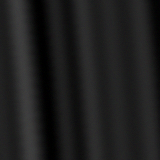

In [18]:
imshow(util.tensor2img(visuals['SR', 0.5, 1]))

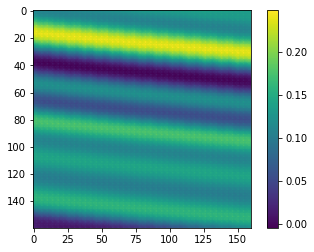

In [19]:
plt.imshow(visuals['SR',0.0,1][0,:,:].T)
plt.colorbar()

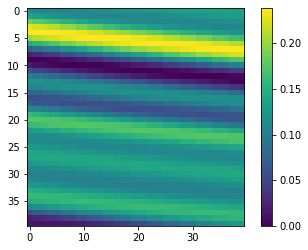

In [20]:
plt.imshow(visuals['LQ'][0,:,:].T)
plt.colorbar()

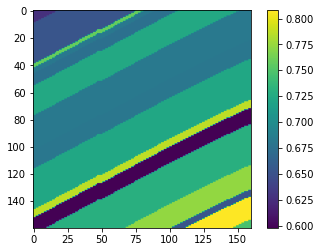

In [21]:
plt.imshow(visuals['GT'][0,:,:].T)
plt.colorbar()

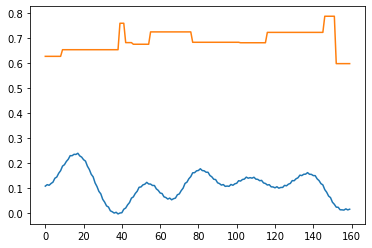

In [22]:
sr = visuals['SR',0.0,1][0,:,:]
gt = visuals['GT'][0,:,:]
lq = visuals['LQ'][0,:,:]


plt.plot(sr[0,:])
plt.plot(gt[0,:])

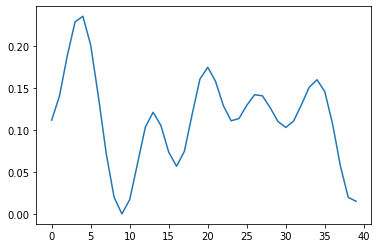

In [23]:
plt.plot(lq[0,:])